# Logistic Regression

We can also use the ELBO to approximate the posterior.

## The Model

The model is the same as Linear Regression, except the output is passed through a Logistic Sigmoid to give output that is on [0,1].

$P(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$

$P(\mathbf{y} \mid \mathbf{X}, \mathbf{w} ) = \sigma(\mathcal{N}(\mathbf{Xw}, \beta^{-1}\mathbf{I}))$

## ELBO

The ELBO is used as the loss function for this model. 

ELBO = $E_{q}[log P(y \mid X, w)] - KL(q(w) || p(w))$

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.datasets import make_classification
%matplotlib inline

In [65]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(LogisticRegression, self).__init__()
        self.approx_mean = torch.nn.Parameter(torch.ones(x_1s.shape[1]))
        self.approx_cov = torch.nn.Parameter(torch.from_numpy(np.arange(1,7)).float())
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.sigmoid = torch.nn.Sigmoid()
        self.prior_mean = torch.from_numpy(np.zeros((in_features,))).float()
        self.prior_cov = torch.from_numpy(np.identity(in_features)).float()
        
    def forward(self, x, w):
        return torch.matmul(x,w)
    
    def forward_with_softmax(self, x,w):
        return self.sigmoid(self.forward(x,w))
    
    def loss(self, x, y, w):
        nll = torch.from_numpy(np.zeros(1)).float()
    
        y_hat = self.forward(x,w)
        app_cov = vec_to_ldiag(self.approx_cov, 3)
        q_cov =torch.matmul(app_cov, app_cov.transpose(0,1))
        
        return self.bce(y_hat, y)-self.analytical_KLD(self.approx_mean, q_cov ,
                                                      torch.zeros_like(self.approx_mean), 
                                                      torch.eye(q_cov.shape[0]))/(x.shape[0]*x.shape[1])
     
    
    def analytical_KLD(self, m1, c1, m2, c2):
        
        trace = torch.trace(torch.matmul(torch.inverse(c2), c1))
        dmu = (m2 - m1).reshape(-1,1)
        mhlbs = torch.matmul(torch.matmul(dmu.transpose(0,1), torch.inverse(c2)), dmu)
        det_ratio = torch.log(torch.det(c2))-torch.log(torch.det(c1))
        return 0.5*(det_ratio+trace+mhlbs+c2.shape[0])
        

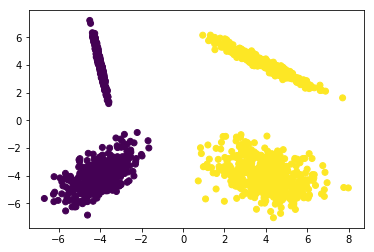

In [66]:
x, y = make_classification(n_samples=2000, flip_y=0, n_features=2, n_informative=2, n_redundant=0, class_sep=4.0)
plt.scatter(x[:,0], x[:,1], c=y)
x_1s = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)

In [67]:
def vec_to_ldiag(vec, size):
    c = torch.zeros(size, size)
    c[torch.tril(torch.ones(size, size)) == 1] = vec
    c[torch.eye(size).byte()] = torch.nn.functional.sigmoid(c[torch.eye(size).byte()])
    return c

In [68]:
lr = LogisticRegression(x_1s.shape[1],1)


approx_chl = vec_to_ldiag(lr.approx_cov, x_1s.shape[1])

mvn = torch.distributions.MultivariateNormal(lr.approx_mean, scale_tril=approx_chl)

In [69]:
opt = torch.optim.Adam(lr.parameters(), lr=0.05)

In [70]:
x_t = torch.autograd.Variable(torch.from_numpy(x_1s).float())
y_t = torch.autograd.Variable(torch.from_numpy(y.reshape(-1,1)).float())
for t in range(5000):
    opt.zero_grad()
    ws = mvn.rsample(torch.Size([1]))
    loss = lr.loss(x_t,y_t, ws.transpose(0,1))
    loss.backward(retain_graph=True)
    opt.step()

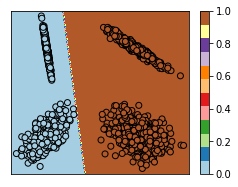

In [74]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy_1s = np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]

Z = lr.forward_with_softmax(torch.from_numpy(xy_1s).float(), lr.approx_mean).data.numpy()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()

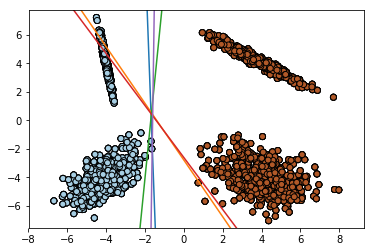

In [75]:
for i in range(5):
    w_sample =  mvn.sample()
    y_hat = lr.forward_with_softmax(x_t, w_sample)
    w_sample = w_sample.data.numpy()
    x1 = np.arange(x_min, x_max, h)
    x2  =(-w_sample[0] - x1*w_sample[1])/w_sample[2]
    plt.plot(x1,x2)
    plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.ylim([y_min,y_max])

# Summary

As the last plot shows, this approximation is not perfect! But the framework is very flexible - we could make q a mixture of normals, and this would make the approximation closer to the true posterior - all that changes is our implementation of q.